# **Titanic prediction**
In this notebook we will try to predict if someone survived to the Titanic. This is my second notebook so any suggestions are welcome. If anyone has any recommendations or tips let me know them in the comments. Enjoy it!

<br>
<br>

![](https://i.imgur.com/HEmI1A5.png)

In [1]:
!pip install feature-engine
!pip install arcticdata=='1.4'

     |████████████████████████████████| 179 kB 594 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import arcticdata.ExploratoryDataAnalysis as eda
import arcticdata.FeatureEngineering as fe
import arcticdata.FeatureSelection as fs

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


<br>
<br>

![](https://i.imgur.com/N16UsDR.png)
Numeric features:
   *     PassengerID: Identifier for each passenger. This feature won´t have value for our model  (Continuous)
   *     Survived: Survival status of the passenger. 1=Survived 0=Deceased. This is the feature that we need to predict in the test set (Discrete)
   *     Pclass: Ticket class. 1=First Class  2=Second Class  3=Third Class  (Discrete)
   *     Age: Age of the passenger  (Continuous)
   *     SibSp: Number of siblings and spouses aboard  (Discrete)
   *     Parch: Number of parents and children aboard  (Discrete)
   *     Fare: Ticket Fare  (Continuous)
        
Categorical features:
   * Cabin: Cabin number. (Alphanumeric)
   * Embarked: Embarkation port. C=Cherbourg  Q=Queenstown  S=Southampton
   * Name: Title and name of the passenger
   * Sex: Male or Female
   * Ticket: Ticket number (Alphanumeric)

In [3]:
train_raw = pd.read_csv('/kaggle/input/titanic/train.csv')
test_raw = pd.read_csv('/kaggle/input/titanic/test.csv')
train = train_raw.copy()
test = test_raw.copy()
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


<br>
<br>

![](https://i.imgur.com/z7cwz70.png)

## Correlations

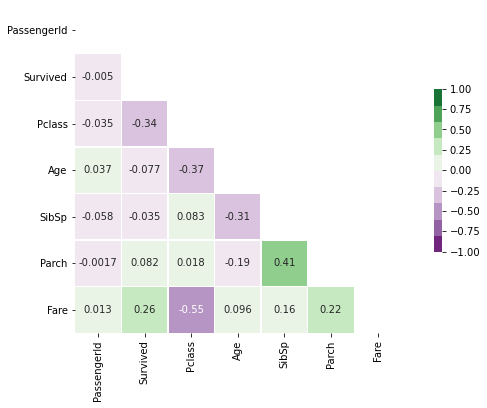

In [4]:
eda.corr_plot(train)

<br>
<br>

# Missing values

Since the variable 'PassengerId' does not provide any value to our models, we will remove it.

Then, we will look at the missing data in training and test set

,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
Fare,0,0.000000
Ticket,0,0.000000


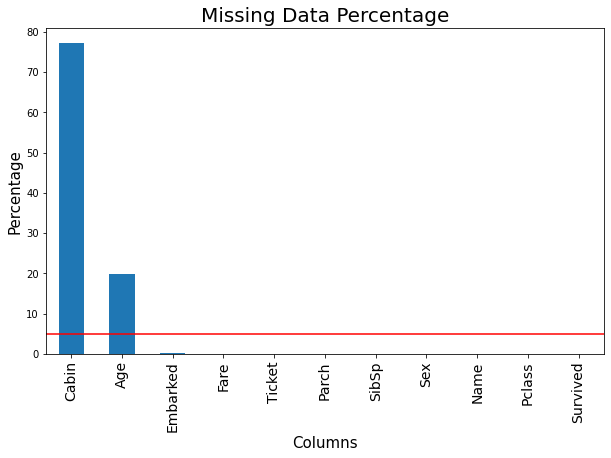

In [5]:
ids=test.PassengerId
train.drop(columns='PassengerId',inplace=True)
test.drop(columns='PassengerId',inplace=True)

eda.missing_data(train,percentage=True).head()

,Total,Percent
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234
Embarked,0,0.000000
Ticket,0,0.000000


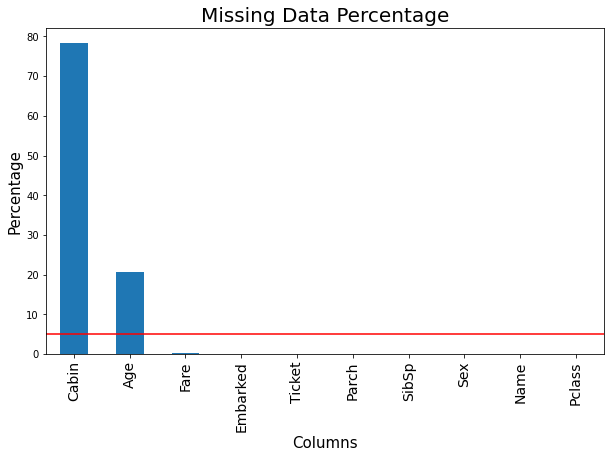

In [6]:
eda.missing_data(test,percentage=True).head()

Missing values may not be missing randomly and their absence may be due to another variable. It is possible that the passenger's cabin or age could not be identified if they didn't survive so we will create a new variable to identify whether or not there was missing data.

<br>
<br>

# Survived

The feature Survived is NUMERIC

-Missing values in training set: 0
-Outliers 1.5*IQR: 0
-Outliers   3*IQR: 0


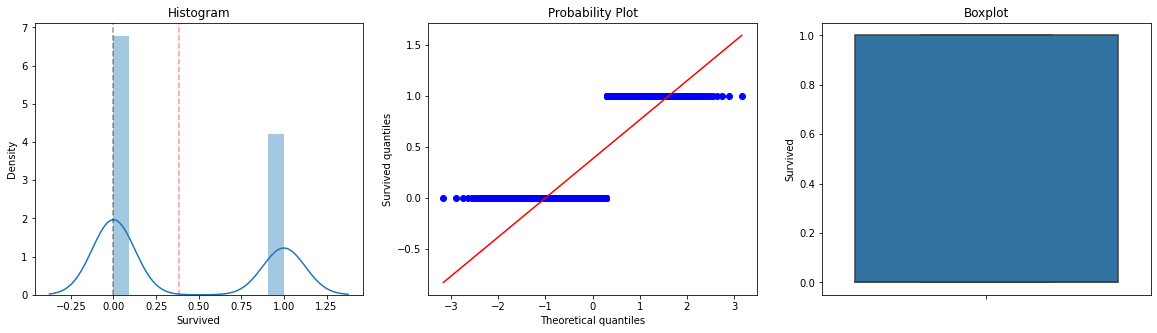

In [7]:
eda.feature_analysis(train,"Survived",test,"Survived")

,Total,Percent
0,549,61.616162
1,342,38.383838


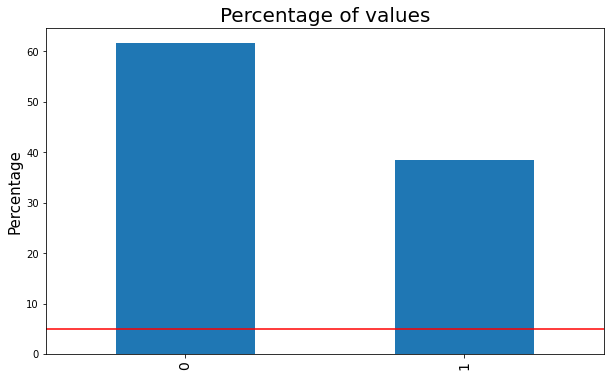

In [8]:
eda.value_counts(train.Survived, percentage=True)

**38.38%** of the passengers survived while the other **61.62%** did not

<br>
<br>

# Pclass

The feature Pclass is NUMERIC

-Missing values in training set: 0
-Missing values in test set    : 0
-Outliers 1.5*IQR: 0
-Outliers   3*IQR: 0


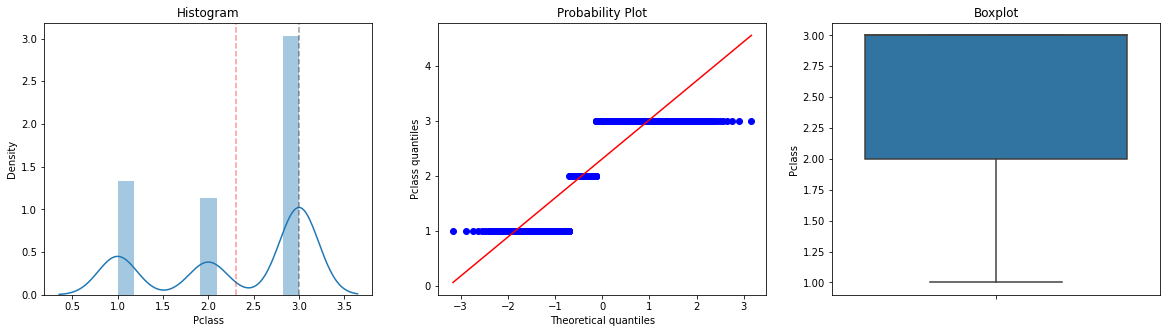

In [9]:
eda.feature_analysis(train,"Pclass",test,"Survived")

,Total,Percent
3,491,55.106622
1,216,24.242424
2,184,20.650954


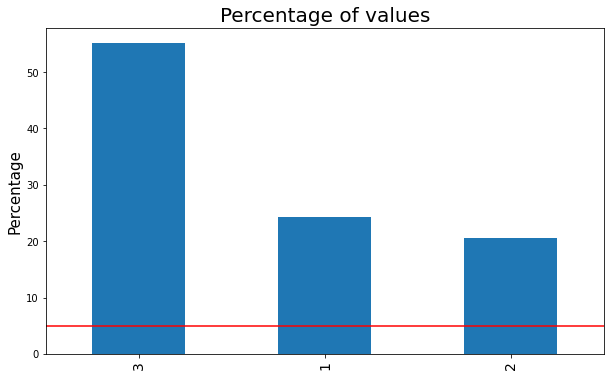

In [10]:
eda.value_counts(train.Pclass,percentage=True)

Most of the passengers were of a lower socio-economic class and therefore traveled in third class. 

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


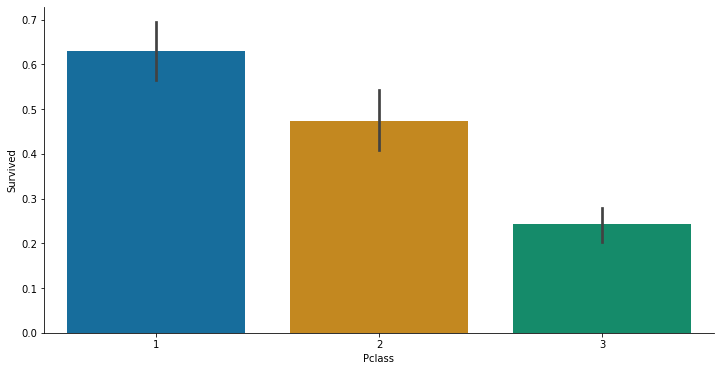

In [11]:
def get_survivors(x):
    print(train[[x,"Survived"]].groupby([x],as_index=False).mean())
    fig, ax = plt.subplots(figsize=(12,6))
    sns.barplot(x=x,y="Survived",data=train,ax=ax,palette='colorblind')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

get_survivors("Pclass")

We can see how about **60%** of first class passengers survived while only about **25%** of third class passengers survived.

<br>
<br>

# Name
The first thing we notice about this variable is its high cardinality, which does not add any value to the model, so we must first reduce this cardinality to keep the important information.

In [12]:
eda.feature_analysis(train,"Name",test,"Survived")

The feature Name is CATEGORICAL

-Cardinality: 891
-Missing values in training set: 0
-Missing values in test set    : 0
-THE CARDINALITY IS TOO BIG


In [13]:
print('Name cardinality: {}'.format(len(train.Name.unique())))

name_status=[]
for x in train.Name.to_list():
    name_status.append(x.split(", ")[1].split('.')[0])
train['Name']=name_status

name_status=[]
for x in test.Name.to_list():
    name_status.append(x.split(", ")[1].split('.')[0])
test['Name']=name_status
print('Name cardinality: {}'.format(len(train.Name.unique())))
train.head()

Name cardinality: 891
Name cardinality: 17


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,Mr,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,Mrs,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,Miss,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,Mrs,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,Mr,male,35.0,0,0,373450,8.0500,NaN,S


In [14]:
train['Name'] = train['Name'].replace('Mlle', 'Miss')
train['Name'] = train['Name'].replace('Ms', 'Miss')
train['Name'] = train['Name'].replace('Mme', 'Mrs')

test['Name'] = test['Name'].replace('Mlle', 'Miss')
test['Name'] = test['Name'].replace('Ms', 'Miss')
test['Name'] = test['Name'].replace('Mme', 'Mrs')

In [15]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,Mr,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,Mrs,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,Miss,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,Mrs,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,Mr,male,35.0,0,0,373450,8.0500,NaN,S


,Total,Percent
Mr,517,58.024691
Miss,185,20.763187
Mrs,126,14.141414
Master,40,4.489338
Dr,7,0.785634


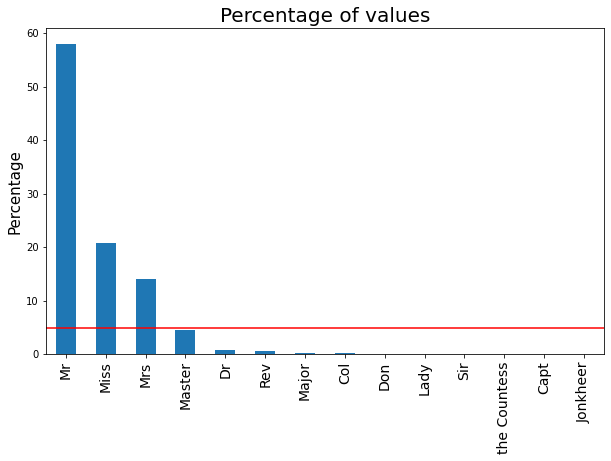

In [16]:
eda.value_counts(train.Name,percentage=True).head()

As we can see in the graph we still have a relatively high cardinality and some categories are below 5% of representativeness so we are going to group these categories creating a new one called 'rare'. 

,Total,Percent
Mr,517,58.024691
Miss,185,20.763187
Mrs,126,14.141414
Rare,63,7.070707


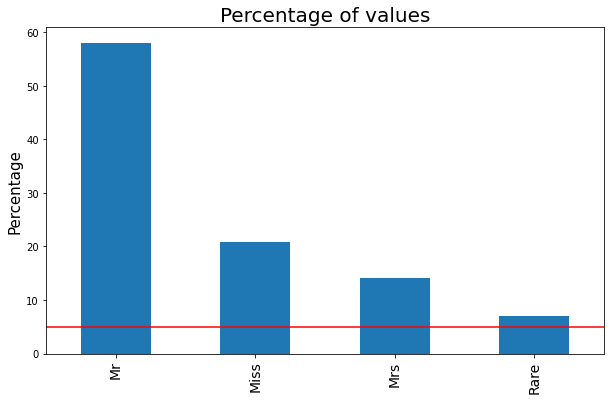

In [17]:
train['Name']=fe.group_rare_labels(train.Name,train.Name)
test['Name']=fe.group_rare_labels(train.Name,test.Name)

eda.value_counts(train.Name,percentage=True)

   Name  Survived
0  Miss  0.702703
1    Mr  0.156673
2   Mrs  0.793651
3  Rare  0.492063


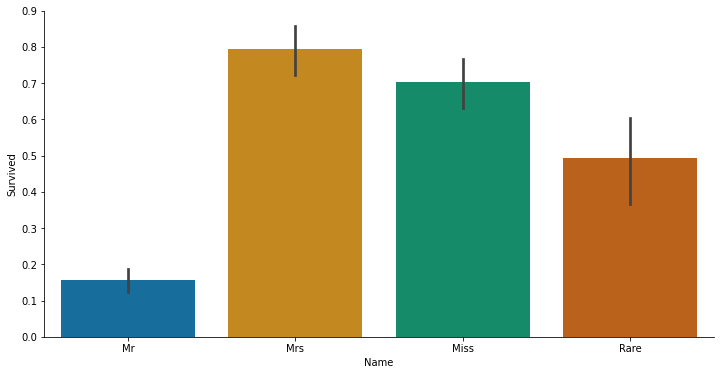

In [18]:
get_survivors("Name")

As we can see, women had much more probability for surviving the disaster

<br>
<br>

# Sex

The feature Sex is CATEGORICAL

-Cardinality: 2
-Missing values in training set: 0
-Missing values in test set    : 0


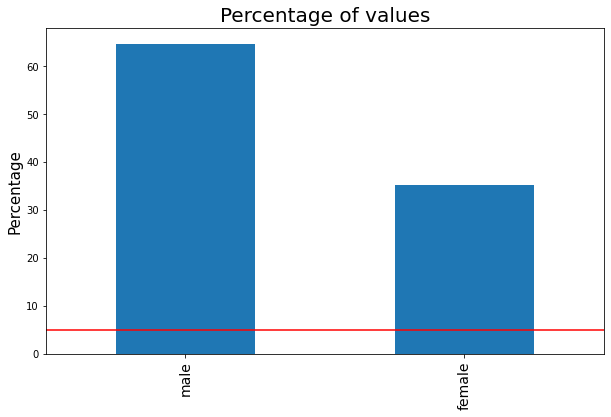

In [19]:
eda.feature_analysis(train,"Sex",test,"Survived")

,Total,Percent
male,577,64.758698
female,314,35.241302


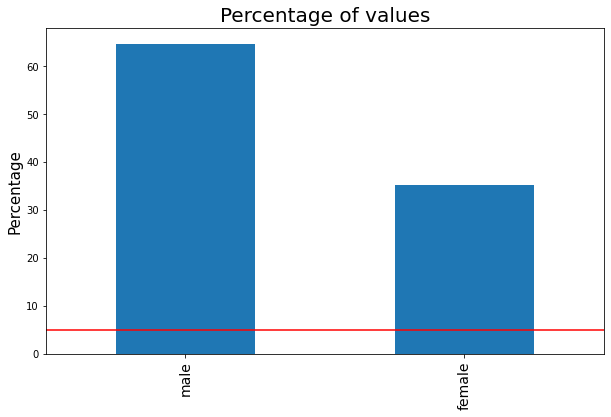

In [20]:
eda.value_counts(train.Sex,percentage=True)

**64.76%** of the passengers were male while **35.24%** of the passengers were female.

      Sex  Survived
0  female  0.742038
1    male  0.188908


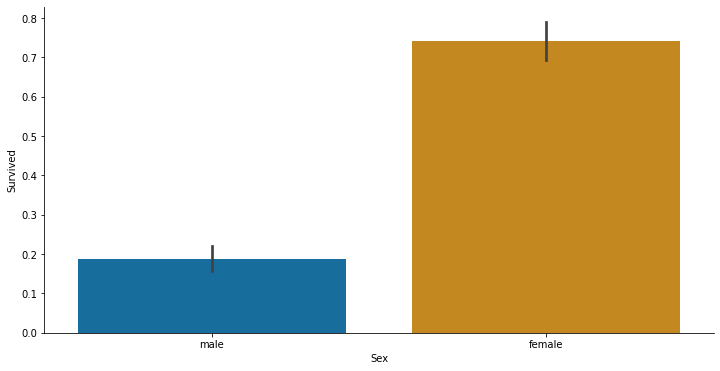

In [21]:
get_survivors("Sex")

The survival rate for female passengers was **74%** while the survival rate for male passengers was **19%**.

<br>
<br>

# Age

The feature Age is NUMERIC

-Missing values in training set: 177
-Missing values in test set    : 86
-Outliers 1.5*IQR: 11
-Outliers   3*IQR: 0


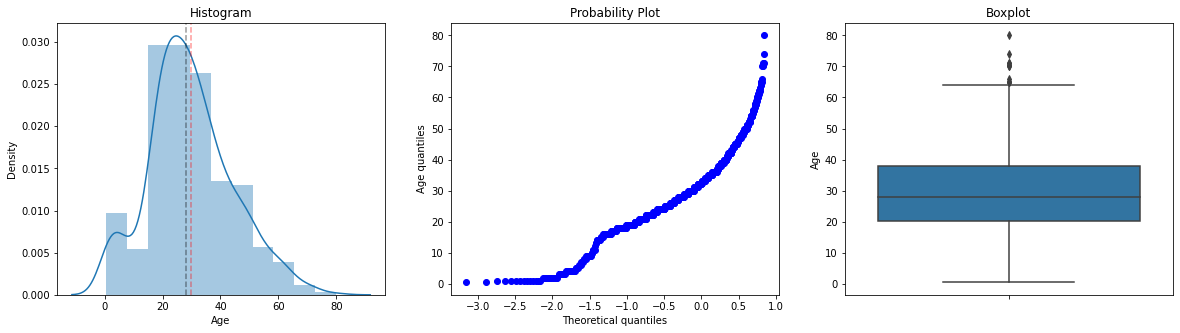

In [22]:
eda.feature_analysis(train,"Age",test,"Survived")

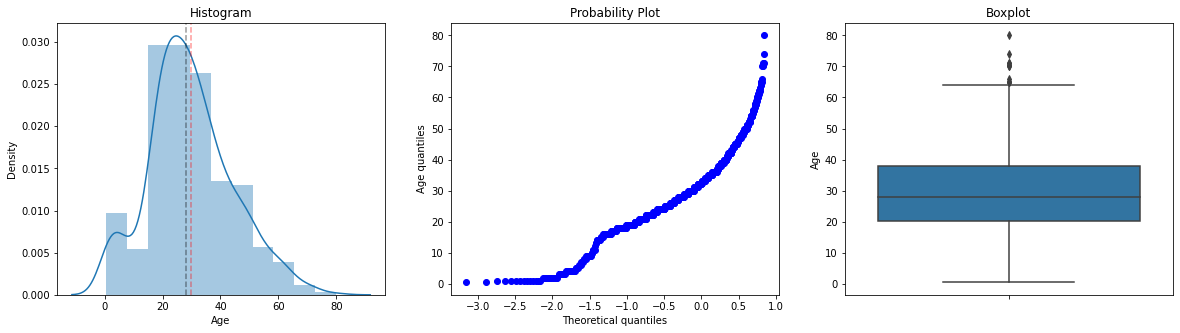

In [23]:
eda.distribution_diag(train,'Age')

We can see how the distribution of the variable 'Age' is almost Gaussian, it presents some outliers and as we saw before, it has 177 NAN in the training set and 86 NAN in the test set.

We create an indicator in the training set and in the test set to see when there were missing values in the original variable in case those values were missing non-randomly.

In [24]:
test = fe.impute_missing(train.drop('Survived',axis=True),test,method='indicator',variables=["Age"])
train = fe.impute_missing(train,train,method='indicator',variables=["Age"])

In [25]:
print(eda.outliers(train,'Age',table=True, method="IQR3").shape)
print(eda.outliers(train,'Age',table=True, method="IQR").shape)

MIN: -33.5
MAX: 91.625
(0, 12)
MIN: -6.6875
MAX: 64.8125
(11, 12)


In [26]:
eda.outliers(train,'Age',table=True,limits=False)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_na
33,0,2,Mr,male,66.0,0,0,C.A. 24579,10.5000,NaN,S,0
54,0,1,Mr,male,65.0,0,1,113509,61.9792,B30,C,0
96,0,1,Mr,male,71.0,0,0,PC 17754,34.6542,A5,C,0
116,0,3,Mr,male,70.5,0,0,370369,7.7500,NaN,Q,0
280,0,3,Mr,male,65.0,0,0,336439,7.7500,NaN,Q,0
456,0,1,Mr,male,65.0,0,0,13509,26.5500,E38,S,0
493,0,1,Mr,male,71.0,0,0,PC 17609,49.5042,NaN,C,0
630,1,1,Mr,male,80.0,0,0,27042,30.0000,A23,S,0
672,0,2,Mr,male,70.0,0,0,C.A. 24580,10.5000,NaN,S,0
745,0,1,Rare,male,70.0,1,1,WE/P 5735,71.0000,B22,S,0


In [27]:
train = fe.impute_missing(train,train,variables=["Age"])
test = fe.impute_missing(train.drop('Survived',axis=1),test,variables=["Age"])
eda.missing_data(train).head(3)

,Total,Percent
Cabin,687,77.104377
Embarked,2,0.224467
Age_na,0,0.000000


In [28]:
eda.missing_data(test).head(3)

,Total,Percent
Cabin,327,78.229665
Fare,1,0.239234
Age_na,0,0.000000


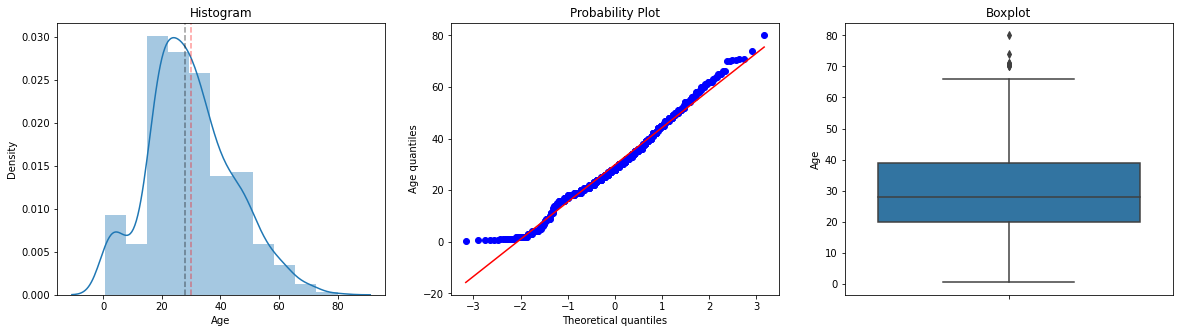

In [29]:
eda.distribution_diag(train,'Age')

Let's create a variable that divides age into intervals of equal frequency to decide which variable best explains the data and other variable that divides age into intervals of equal range

In [30]:
test["AgeFreq"] = fe.discretization(train.drop('Survived',axis=1),test,variables=['Age'])['Age']
train["AgeFreq"] = fe.discretization(train,train,variables=['Age'])['Age']
test["AgeRange"] = fe.discretization(train.drop('Survived',axis=1),test,variables=['Age'],method="equalrange")['Age']
train["AgeRange"] = fe.discretization(train,train,variables=['Age'],method="equalrange")['Age']
train.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_na,AgeFreq,AgeRange
0,0,3,Mr,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,2,2
1,1,1,Mrs,female,38.0,1,0,PC 17599,71.2833,C85,C,0,7,4
2,1,3,Miss,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,4,3


<br>
<br>

# FamilySize

We are going to create a new variable to indicate the size of the family through the variables SibSp and Parch.

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


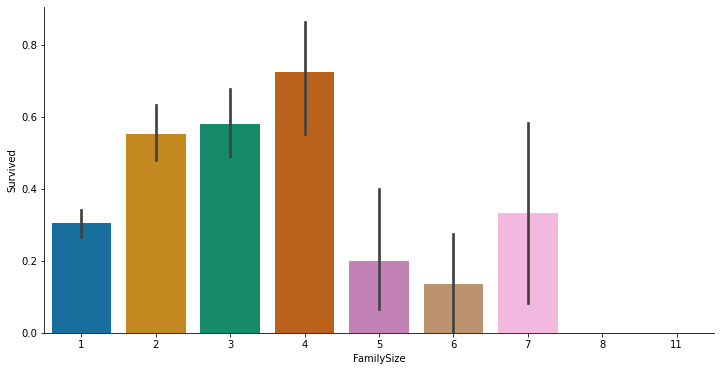

In [31]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

get_survivors("FamilySize")

We can see how the probability of surviving increases to a family of 4 and then decreases.

<br>
<br>

# IsAlone

Let's create another variable to indicate whether a passenger was traveling alone or not.

In [32]:
train['IsAlone'] = 0
train.loc[train['FamilySize'] == 1, 'IsAlone'] = 1
test['IsAlone'] = 0
test.loc[test['FamilySize'] == 1, 'IsAlone'] = 1

In [33]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_na,AgeFreq,AgeRange,FamilySize,IsAlone
0,0,3,Mr,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,2,2,2,0
1,1,1,Mrs,female,38.0,1,0,PC 17599,71.2833,C85,C,0,7,4,2,0
2,1,3,Miss,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,4,3,1,1
3,1,1,Mrs,female,35.0,1,0,113803,53.1000,C123,S,0,6,4,2,0
4,0,3,Mr,male,35.0,0,0,373450,8.0500,NaN,S,0,6,4,1,1


<br>
<br>

# SibSp

The feature SibSp is NUMERIC

-Missing values in training set: 0
-Missing values in test set    : 0
-Outliers 1.5*IQR: 46
-Outliers   3*IQR: 12


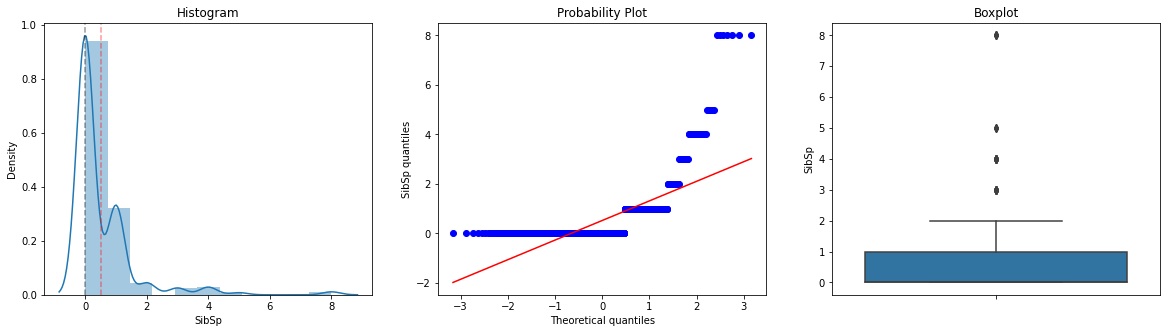

In [34]:
eda.feature_analysis(train,"SibSp",test,"Survived")

,Total,Percent
0,608,68.237935
1,209,23.456790
2,28,3.142536
4,18,2.020202
3,16,1.795735
8,7,0.785634
5,5,0.561167


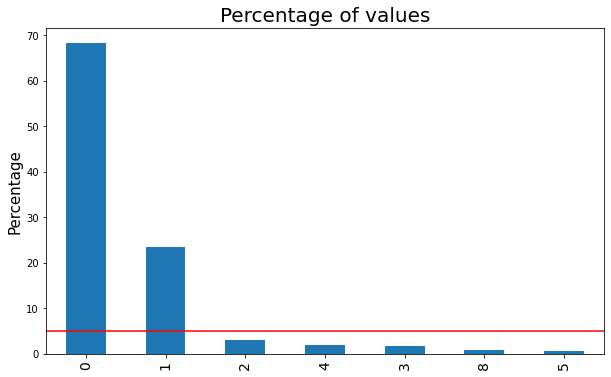

In [35]:
eda.value_counts(train.SibSp,percentage=True)

   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000


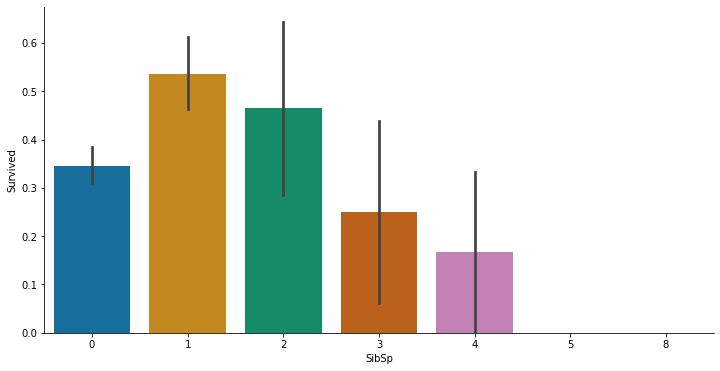

In [36]:
get_survivors("SibSp")

<br>
<br>

# Parch

The feature Parch is NUMERIC

-Missing values in training set: 0
-Missing values in test set    : 0
-Outliers 1.5*IQR: 213
-Outliers   3*IQR: 213


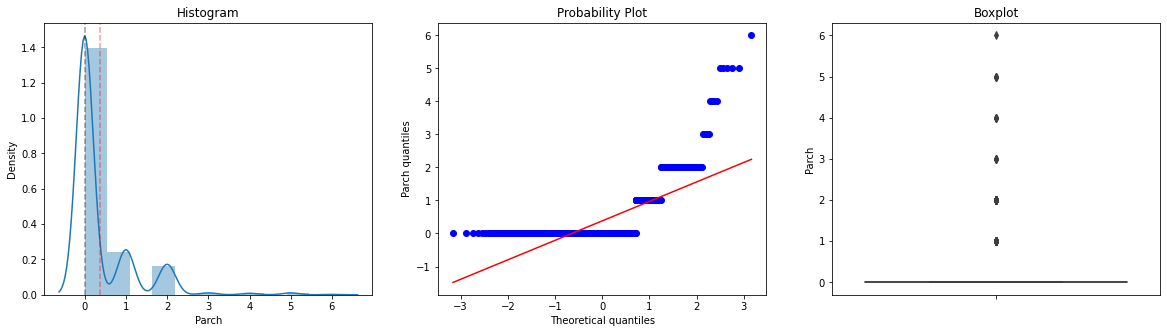

In [37]:
eda.feature_analysis(train,"Parch",test,"Survived")

,Total,Percent
0,678,76.094276
1,118,13.243547
2,80,8.978676
5,5,0.561167
3,5,0.561167
4,4,0.448934
6,1,0.112233


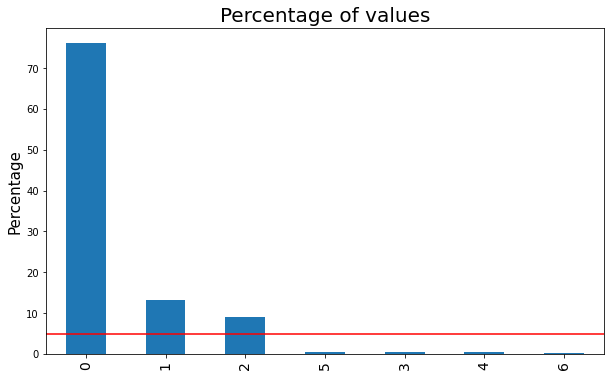

In [38]:
eda.value_counts(train.Parch,percentage=True)

   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000


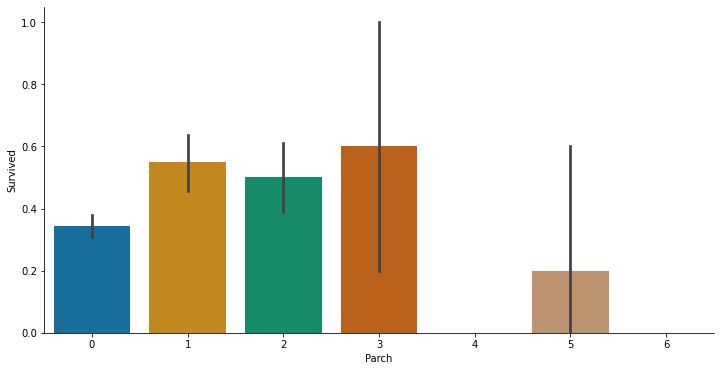

In [39]:
get_survivors("Parch")

<br>
<br>

# Ticket

In [40]:
eda.feature_analysis(train,"Ticket",test,"Survived")

The feature Ticket is CATEGORICAL

-Cardinality: 681
-Missing values in training set: 0
-Missing values in test set    : 0
-THE CARDINALITY IS TOO BIG


In [41]:
train.Ticket.head(8)

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
5              330877
6               17463
7              349909
Name: Ticket, dtype: object

In [42]:
print("Ticket cardinality: {}".format(len(train.Ticket.unique())))

Ticket cardinality: 681


The variable 'Ticket' also has a high cardinality and it seems that we cannot extract any useful information from the variable so we will remove it.

In [43]:
train.drop(columns='Ticket',inplace=True)
test.drop(columns='Ticket',inplace=True)

<br>
<br>

# Fare

The feature Fare is NUMERIC

-Missing values in training set: 0
-Missing values in test set    : 1
-Outliers 1.5*IQR: 116
-Outliers   3*IQR: 53


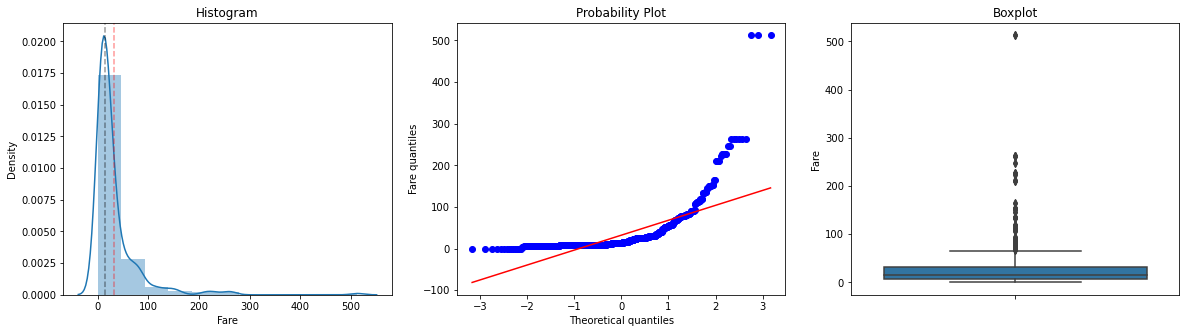

In [44]:
eda.feature_analysis(train,"Fare",test,"Survived")

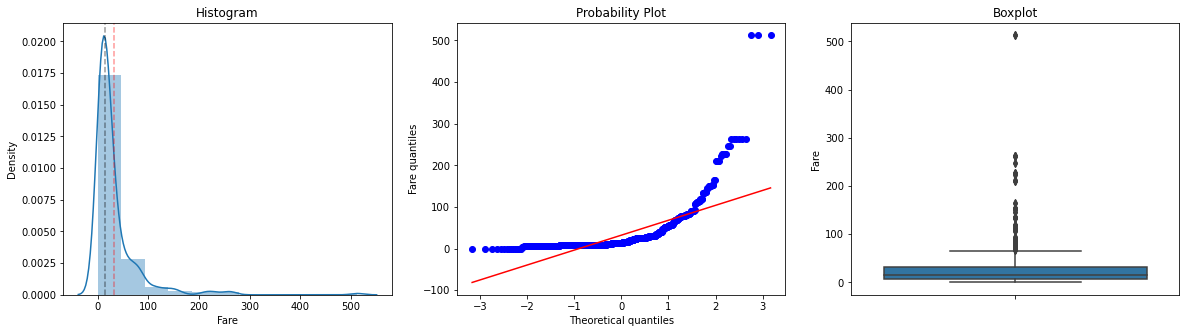

In [45]:
eda.distribution_diag(train,'Fare')

The 'fare' variable is asymmetric, has missing data and also has several outliers (some closer and some further).

In [46]:
eda.outliers(train,'Fare',table=True,limits=False,method="IQR3").shape

(53, 15)

As we can see, there are 116 outliers so we will have to transform the variable to improve its distribution and reduce the outliers.

In [47]:
train=fe.impute_missing(train,train,variables=['Fare'])
test=fe.impute_missing(train.drop('Survived',axis=1),test,variables=['Fare'])

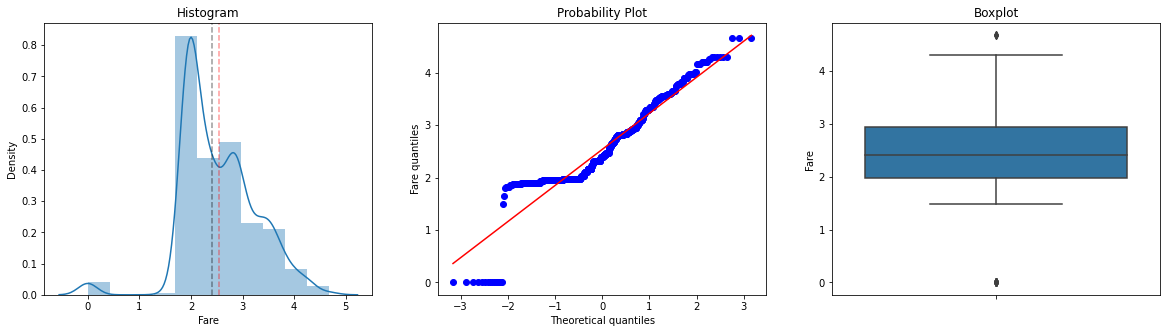

In [48]:
train=fe.transform(train,variables='Fare',method='yeo')
test=fe.transform(test,variables='Fare',method='yeo')
eda.distribution_diag(train,'Fare')

In [49]:
eda.outliers(train,'Fare',table=True,limits=False,method="IQR3").shape

(0, 15)

We have performed the transformation with Yeo-Johnson's method and when checking the number of outliers we see that the number of outliers has gone from 116 to 18. We will treat outliers as missing values to be imputed by performing a simple random sampling.

In [50]:
eda.missing_data(train).head(3)

,Total,Percent
Cabin,687,77.104377
Embarked,2,0.224467
IsAlone,0,0.000000


In [51]:
eda.missing_data(test).head(3)

,Total,Percent
Cabin,327,78.229665
IsAlone,0,0.000000
FamilySize,0,0.000000


We will divide the fare variable into ranges with the same frequency as for age

In [52]:
test["FareFreq"] = fe.discretization(train.drop('Survived',axis=1),test,variables=['Fare'])['Fare']
train["FareFreq"] = fe.discretization(train,train,variables=['Fare'])['Fare']
test["FareRange"] = fe.discretization(train.drop('Survived',axis=1),test,variables=['Fare'],method="equalrange")['Fare']
train["FareRange"] = fe.discretization(train,train,variables=['Fare'],method="equalrange")['Fare']

<br>
<br>

# Cabin

In [53]:
eda.feature_analysis(train,"Cabin",test,"Survived")

The feature Cabin is CATEGORICAL

-Cardinality: 148
-Missing values in training set: 687
-Missing values in test set    : 327
-THE CARDINALITY IS TOO BIG


In [54]:
print("Cabin cardinality: {}".format(len(train.Cabin.unique())))

Cabin cardinality: 148


The variable 'Cabin' also has a very high cardinality so we will have to reduce it. For this purpose, we will keep only the letter of the cabin

Cabin cardinality: 9


,Total,Percent
C,59,6.621773
B,47,5.274972
D,33,3.703704
E,32,3.591470
A,15,1.683502
F,13,1.459035
G,4,0.448934
T,1,0.112233


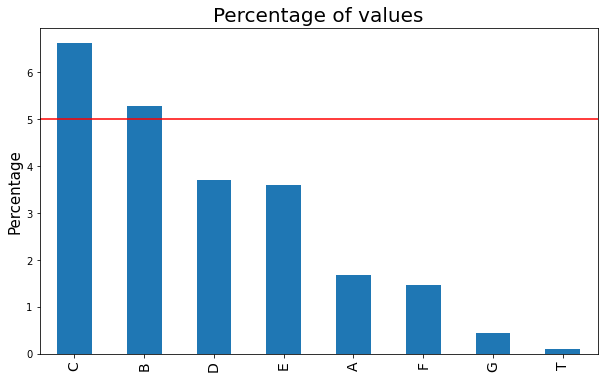

In [55]:
train['Cabin']=train.Cabin.str[0]
test['Cabin']=test.Cabin.str[0]
print("Cabin cardinality: {}".format(len(train.Cabin.unique())))
eda.value_counts(train.Cabin,percentage=True)

As before, we replace the missing values with a random sample so as not to modify the original distribution of the variable.

In [56]:
test=fe.impute_missing(train.drop('Survived',axis=1),test,variables=['Cabin'],method='indicator')
train=fe.impute_missing(train,train,variables=['Cabin'],method='indicator')
train=fe.impute_missing(train,train,variables=['Cabin'])
test=fe.impute_missing(train.drop('Survived',axis=1),test,variables=['Cabin'])
eda.missing_data(train).head(3)

,Total,Percent
Embarked,2,0.224467
Cabin_na,0,0.000000
Fare,0,0.000000


In [57]:
eda.missing_data(test).head(3)

,Total,Percent
Cabin_na,0,0.0
Cabin,0,0.0
Name,0,0.0


Some categories are below 5% of representativeness so we are going to group these categories creating a new one called 'rare'. This will help when putting it into production

,Total,Percent
C,261,29.292929
B,184,20.650954
D,155,17.396184
E,150,16.835017
A,63,7.070707
F,59,6.621773
Rare,19,2.132435


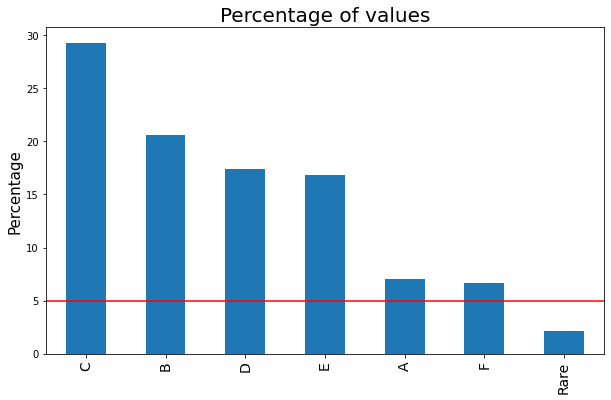

In [58]:
train['Cabin']=fe.group_rare_labels(train.Cabin,train.Cabin)
test['Cabin']=fe.group_rare_labels(train.drop('Survived',axis=1).Cabin,test.Cabin)

eda.value_counts(train.Cabin,percentage=True)

  Cabin  Survived
0     A  0.412698
1     B  0.445652
2     C  0.310345
3     D  0.412903
4     E  0.386667
5     F  0.406780
6  Rare  0.368421


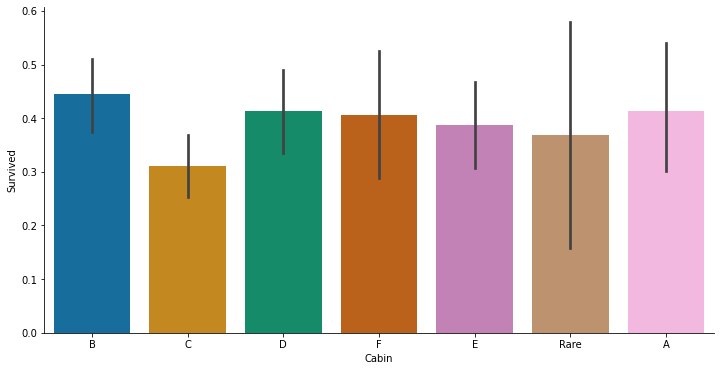

In [59]:
get_survivors("Cabin")

<br>
<br>

# Embarked

The feature Embarked is CATEGORICAL

-Cardinality: 4
-Missing values in training set: 2
-Missing values in test set    : 0


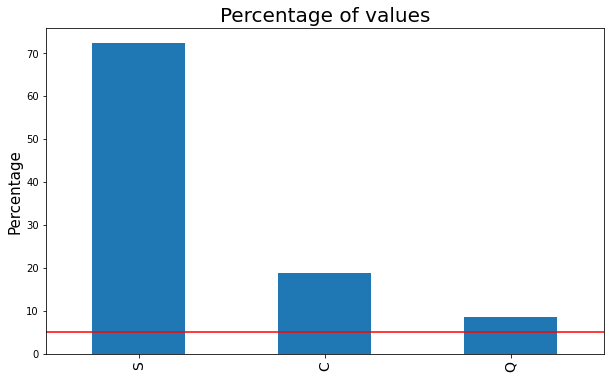

In [60]:
eda.feature_analysis(train,"Embarked",test,"Survived")

,Total,Percent
S,644,72.278339
C,168,18.855219
Q,77,8.641975


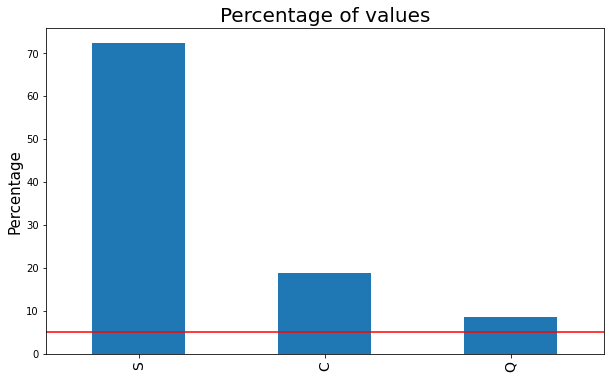

In [61]:
eda.value_counts(train.Embarked,percentage=True)

Most of the passengers boarded at Southampton. 

In [62]:
train=fe.impute_missing(train,train,variables=['Embarked'])
test=fe.impute_missing(train.drop('Survived',axis=1),test,variables=['Embarked'])
eda.missing_data(train).head(3)

,Total,Percent
Cabin_na,0,0.0
FareRange,0,0.0
Pclass,0,0.0


In [63]:
eda.missing_data(test).head(3)

,Total,Percent
Cabin_na,0,0.0
Cabin,0,0.0
Name,0,0.0


In [64]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Age_na,AgeFreq,AgeRange,FamilySize,IsAlone,FareFreq,FareRange,Cabin_na
0,0,3,Mr,male,22.0,1,0,1.906724,B,S,0,2,2,2,0,0,4,1
1,1,1,Mrs,female,38.0,1,0,3.497640,C,C,0,7,4,2,0,8,7,0
2,1,3,Miss,female,26.0,0,0,1.970459,D,S,0,4,3,1,1,2,4,1
3,1,1,Mrs,female,35.0,1,0,3.304258,C,S,0,6,4,2,0,8,7,0
4,0,3,Mr,male,35.0,0,0,1.981680,F,S,0,6,4,1,1,2,4,1


<br>
<br>
<br>
<br>
<br>

In [65]:
train.shape,test.shape

((891, 18), (418, 17))

In [66]:
test = fe.encoding(train.drop('Survived',axis=1),test,variables=['Name','Cabin','Embarked','Sex'],drop_last=False)
train = fe.encoding(train,train,variables=['Name','Cabin','Embarked','Sex'],drop_last=False)

In [67]:
train.shape,test.shape

((891, 30), (418, 29))

In [68]:
testcols = test.columns.values.tolist()
traincols = train.columns.values.tolist()
print(traincols)
print(testcols)

['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_na', 'AgeFreq', 'AgeRange', 'FamilySize', 'IsAlone', 'FareFreq', 'FareRange', 'Cabin_na', 'Name_Mr', 'Name_Mrs', 'Name_Miss', 'Name_Rare', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_F', 'Cabin_E', 'Cabin_Rare', 'Cabin_A', 'Embarked_S', 'Embarked_C', 'Embarked_Q', 'Sex_male', 'Sex_female']
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_na', 'AgeFreq', 'AgeRange', 'FamilySize', 'IsAlone', 'FareFreq', 'FareRange', 'Cabin_na', 'Name_Mr', 'Name_Mrs', 'Name_Miss', 'Name_Rare', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_F', 'Cabin_E', 'Cabin_Rare', 'Cabin_A', 'Embarked_S', 'Embarked_C', 'Embarked_Q', 'Sex_male', 'Sex_female']


In [69]:
train.dtypes

Survived        int64
Pclass          int64
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Age_na          int64
AgeFreq         int64
AgeRange        int64
FamilySize      int64
IsAlone         int64
FareFreq        int64
FareRange       int64
Cabin_na        int64
Name_Mr         int64
Name_Mrs        int64
Name_Miss       int64
Name_Rare       int64
Cabin_B         int64
Cabin_C         int64
Cabin_D         int64
Cabin_F         int64
Cabin_E         int64
Cabin_Rare      int64
Cabin_A         int64
Embarked_S      int64
Embarked_C      int64
Embarked_Q      int64
Sex_male        int64
Sex_female      int64
dtype: object

In [70]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Age_na,AgeFreq,AgeRange,FamilySize,...,Cabin_D,Cabin_F,Cabin_E,Cabin_Rare,Cabin_A,Embarked_S,Embarked_C,Embarked_Q,Sex_male,Sex_female
0,0,3,22.0,1,0,1.906724,0,2,2,2,...,0,0,0,0,0,1,0,0,1,0
1,1,1,38.0,1,0,3.497640,0,7,4,2,...,0,0,0,0,0,0,1,0,0,1
2,1,3,26.0,0,0,1.970459,0,4,3,1,...,1,0,0,0,0,1,0,0,0,1
3,1,1,35.0,1,0,3.304258,0,6,4,2,...,0,0,0,0,0,1,0,0,0,1
4,0,3,35.0,0,0,1.981680,0,6,4,1,...,0,1,0,0,0,1,0,0,1,0


In [71]:
X_train = train.drop("Survived", axis=1)
y_train = train["Survived"]
X_test  = test
X_train.shape, y_train.shape, X_test.shape

((891, 29), (891,), (418, 29))

In [72]:
X_train = fe.scale(X_train)
X_test = fe.scale(X_test)

In [73]:
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Age_na,AgeFreq,AgeRange,FamilySize,IsAlone,...,Cabin_D,Cabin_F,Cabin_E,Cabin_Rare,Cabin_A,Embarked_S,Embarked_C,Embarked_Q,Sex_male,Sex_female
0,1.0,0.271174,0.125,0.0,0.408170,0.0,0.222222,0.222222,0.1,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.472229,0.125,0.0,0.748736,0.0,0.777778,0.444444,0.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.0,0.321438,0.000,0.0,0.421814,0.0,0.444444,0.333333,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.434531,0.125,0.0,0.707339,0.0,0.666667,0.444444,0.1,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.434531,0.000,0.0,0.424216,0.0,0.666667,0.444444,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


<br>
<br>
<br>
<br>
<br>

![](https://i.imgur.com/7XqqaQE.png)

In [74]:
import pickle
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=0.2, random_state=0)

In [75]:
np.savez_compressed("np_savez_comp", X=X_train, y=y_train)
data = np.load("np_savez_comp.npz")

X = data["X"]
y = data["y"]

# Naive Bayes

In [76]:
def confusion_plot():
    print(classification_report(y_valid,predicted))
    matrix = confusion_matrix(y_valid, predicted)
    sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues', square=True)
    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.show()

NB score: 0.7877094972067039


              precision    recall  f1-score   support

           0       0.88      0.75      0.81       110
           1       0.68      0.84      0.75        69

    accuracy                           0.79       179
   macro avg       0.78      0.80      0.78       179
weighted avg       0.81      0.79      0.79       179



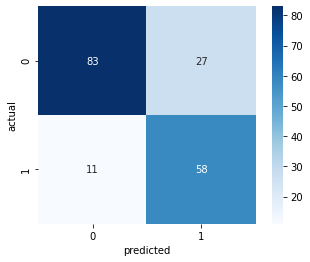

In [77]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

gnb = GaussianNB()
gnb.fit(X_train, y_train)

with open('Naive Bayes.pickle', mode='wb') as fp:
    pickle.dump(gnb, fp)
    
score = gnb.score(X_valid, y_valid)
print('NB score: {}\n\n' .format(score))

predicted=gnb.predict(X_valid)


confusion_plot()

# Logistic Regression

LR score: 0.8100558659217877


              precision    recall  f1-score   support

           0       0.85      0.84      0.84       110
           1       0.75      0.77      0.76        69

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



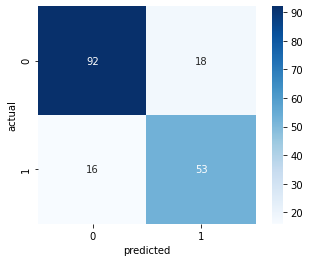

In [78]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(random_state=0)
logistic_regression.fit(X_train, y_train)

with open('Logistic Regression.pickle', mode='wb') as fp:
    pickle.dump(logistic_regression, fp)

score = logistic_regression.score(X_valid, y_valid)
print('LR score: {}\n\n' .format(score))

predicted=logistic_regression.predict(X_valid)



confusion_plot()

# Support Vector Classifier

SVC linear score: 0.7821229050279329


SVC rbf score: 0.8212290502793296


              precision    recall  f1-score   support

           0       0.84      0.79      0.82       110
           1       0.70      0.77      0.73        69

    accuracy                           0.78       179
   macro avg       0.77      0.78      0.77       179
weighted avg       0.79      0.78      0.78       179



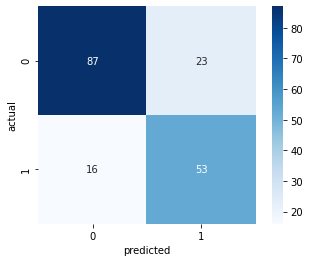

In [79]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1.0, random_state=0)
svm.fit(X_train, y_train)

with open('Support Vector Machine.pickle', mode='wb') as fp:
    pickle.dump(svm, fp)
    
score = svm.score(X_valid, y_valid)
print('SVC linear score: {}\n\n' .format(score))


svm2 = SVC(kernel='rbf', C=1.0, random_state=0)
svm2.fit(X_train, y_train)
score = svm2.score(X_valid, y_valid)
print('SVC rbf score: {}\n\n' .format(score))

predicted=svm.predict(X_valid)



confusion_plot()

# K Nearest Neighbor

KNN score: 0.7988826815642458


              precision    recall  f1-score   support

           0       0.82      0.86      0.84       110
           1       0.76      0.70      0.73        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179



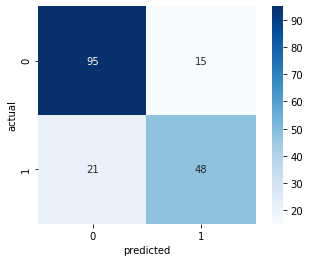

In [80]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train, y_train)

with open('Nearest Neighbors.pickle', mode='wb') as fp:
    pickle.dump(knn, fp)
    
score = knn.score(X_valid, y_valid)
print('KNN score: {}\n\n' .format(score))

predicted=knn.predict(X_valid)


confusion_plot()

# Decision Tree

DT score: 0.8100558659217877


              precision    recall  f1-score   support

           0       0.83      0.86      0.85       110
           1       0.77      0.72      0.75        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



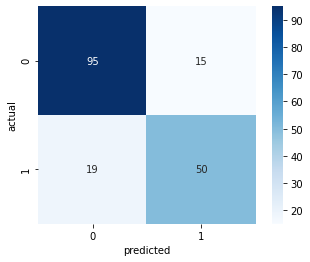

In [81]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(criterion='entropy',random_state=0)
decision_tree.fit(X_train, y_train)

with open('Decision Tree.pickle', mode='wb') as fp:
    pickle.dump(decision_tree, fp)
    
score = decision_tree.score(X_valid, y_valid)
print('DT score: {}\n\n' .format(score))

predicted=decision_tree.predict(X_valid)


confusion_plot()

# Random Forest

RF score: 0.8268156424581006


              precision    recall  f1-score   support

           0       0.85      0.87      0.86       110
           1       0.79      0.75      0.77        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



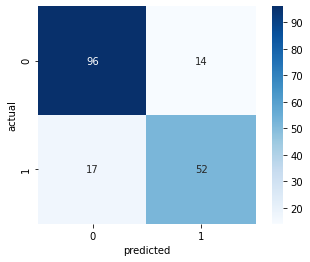

In [82]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(random_state=0)
random_forest.fit(X_train, y_train)

with open('Random Forest.pickle', mode='wb') as fp:
    pickle.dump(random_forest, fp)
    
score = random_forest.score(X_valid, y_valid)
print('RF score: {}\n\n' .format(score))

predicted=random_forest.predict(X_valid)


confusion_plot()

# Extreme Gradient Boosting

[21:39:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
score: 0.8100558659217877


              precision    recall  f1-score   support

           0       0.83      0.87      0.85       110
           1       0.78      0.71      0.74        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



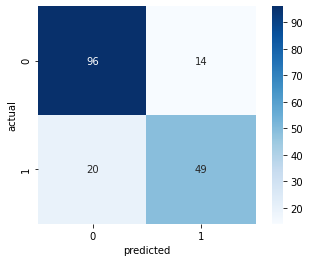

In [83]:
from xgboost import XGBClassifier

xgb = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100)
xgb.fit(X_train, y_train)

with open('Gradient Boosting.pickle', mode='wb') as fp:
    pickle.dump(xgb, fp)
    
score = xgb.score(X_valid, y_valid)
print('score: {}\n\n' .format(score))

predicted=xgb.predict(X_valid)


confusion_plot()

# Best Model

In [84]:
names = ["Support Vector Machine", "Logistic Regression", "Nearest Neighbors",
         "Decision Tree","Random Forest", "Naive Bayes","Gradient Boosting"]

result = []
print("For guessing the Survived feature we used the following models:")
print(" ")
for name in names:
    with open(name + '.pickle', 'rb') as fp:
        clf = pickle.load(fp)
    
    clf.fit(X_train, y_train)
    score1 = clf.score(X_train, y_train)
    score2 = clf.score(X_valid, y_valid)
    result.append([score1, score2])
    
    print(name)

df_result = pd.DataFrame(result, columns=['Training', 'Validation'], index = names)
df_result.sort_values("Validation",ascending=False)

For guessing the Survived feature we used the following models:
 
Support Vector Machine
Logistic Regression
Nearest Neighbors
Decision Tree
Random Forest
Naive Bayes
[21:40:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Gradient Boosting


,Training,Validation
Random Forest,1.000000,0.826816
Logistic Regression,0.828652,0.810056
Decision Tree,1.000000,0.810056
Gradient Boosting,0.879213,0.810056
Nearest Neighbors,0.860955,0.798883
Naive Bayes,0.807584,0.787709
Support Vector Machine,0.823034,0.782123


![](https://i.imgur.com/TdKX2gW.png)

In [85]:
model=RandomForestClassifier(random_state=0)
fs.step_forward(X_train,y_train,model=model,kfeatures=29,info=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:   14.5s finished

[2021-08-11 21:40:15] Features: 1/29 -- score: 0.7841766843723791[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:   14.0s finished

[2021-08-11 21:40:29] Features: 2/29 -- score: 0.8419510862200267[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   15.1s finished

[2021-08-11 21:40:44] Features: 3/29 -- score: 0.8588307368709941[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [86]:
model=RandomForestClassifier(random_state=0)
fs.step_forward(X_train,y_train,model=model,kfeatures=19,info=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:   15.0s finished

[2021-08-11 21:44:19] Features: 1/19 -- score: 0.7841766843723791[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:   14.3s finished

[2021-08-11 21:44:33] Features: 2/19 -- score: 0.8419510862200267[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   13.6s finished

[2021-08-11 21:44:47] Features: 3/19 -- score: 0.8588307368709941[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

['Pclass',
 'SibSp',
 'Fare',
 'Age_na',
 'AgeRange',
 'FamilySize',
 'IsAlone',
 'Cabin_na',
 'Name_Mr',
 'Name_Rare',
 'Cabin_B',
 'Cabin_F',
 'Cabin_E',
 'Cabin_Rare',
 'Embarked_S',
 'Embarked_C',
 'Embarked_Q',
 'Sex_male',
 'Sex_female']

In [87]:
features = ['Pclass','SibSp','Fare','Age_na','AgeRange','FamilySize','IsAlone','Cabin_na','Name_Mr','Name_Rare','Cabin_B','Cabin_F',
            'Cabin_E','Cabin_Rare','Embarked_S','Embarked_C','Embarked_Q','Sex_male','Sex_female']
X_test = X_test[features]
X_train = X_train[features]
X_valid = X_valid[features]

In [88]:
COVERAGE95=0.95
COVERAGE99=0.99
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)

contributions = pca.explained_variance_ratio_
coverages = pca.explained_variance_ratio_.cumsum()
k95 = np.argmax(coverages >= COVERAGE95)
k99 = np.argmax(coverages >= COVERAGE99)

print("k-th primary component for 95% coverage is {}".format(k95 + 1))
print("k-th primary component for 99% coverage is {}".format(k99 + 1))

k-th primary component for 95% coverage is 11
k-th primary component for 99% coverage is 14


In [89]:
pca = PCA(n_components=14)
pca.fit(X_train)
#print(pca.explained_variance_ratio_)
x=pca.transform(X_train)
X_train = pd.DataFrame(x)

![](https://i.imgur.com/z3KMxLA.png)

In [90]:
from sklearn.model_selection import RandomizedSearchCV
params =  {'n_estimators': [100,500,1000,1500,2000], 
                                  'bootstrap': [True,False],
                                  'max_depth': [3,5,10,20,50,75,100,None],
                                  'max_features': ['auto','sqrt'],
                                  'min_samples_leaf': [1,2,4,6,8,10,12,14,16,18,20],
                                  'min_samples_split': [2,5,10,15,20,25,30,35]}

clf = RandomizedSearchCV(random_forest, params, cv=10, return_train_score=True)
best_clf = clf.fit(X_train,y_train)
best_clf

means=clf.cv_results_["mean_test_score"]
stds=clf.cv_results_["std_test_score"]
params=clf.cv_results_["params"]

for m,s,p in zip(means,stds,params):
    print("%0.3f (+/-%0.3f) for %r"%(m,2*s,p))
    
print("="*100)
print("="*100)

print('best score: {:0.3f}'.format(clf.score(X_train, y_train)))
print('best params: {}'.format(clf.best_params_))
print('best val score:  {:0.3f}'.format(clf.best_score_))

0.830 (+/-0.044) for {'n_estimators': 100, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 75, 'bootstrap': True}
0.840 (+/-0.073) for {'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 3, 'bootstrap': True}
0.843 (+/-0.065) for {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 5, 'bootstrap': False}
0.836 (+/-0.074) for {'n_estimators': 1000, 'min_samples_split': 30, 'min_samples_leaf': 18, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
0.843 (+/-0.075) for {'n_estimators': 1500, 'min_samples_split': 25, 'min_samples_leaf': 10, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}
0.823 (+/-0.058) for {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
0.840 (+/-0.079) for {'n_estimators': 1500, 'min_samples_split': 15, 'min_samples_leaf': 2

# We take the best model for predicting

In [91]:
pca = PCA(n_components=14)
pca.fit(X_test)
#print(pca.explained_variance_ratio_)
x=pca.transform(X_test)
X_test = pd.DataFrame(x)

In [92]:
best_model=RandomForestClassifier(n_estimators=500,bootstrap=False,max_depth=None,max_features='sqrt',min_samples_leaf=20,min_samples_split=5)

In [93]:
best_model.fit(X_train,y_train)
preds=best_model.predict(X_test)

In [94]:
pd.DataFrame(preds)

,0
0,0
1,0
2,0
3,0
4,0
...,...
413,0
414,1
415,0
416,0


# Creating the Submission File

In [95]:
output = pd.DataFrame({ "PassengerId" : ids, "Survived": preds })
output.to_csv("submission.csv", index=False)

# Hope you liked it! Upvote if you liked and comment if you have any tip!